# random mask

In [2]:
# packages
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.layers.embeddings import GridEmbedding2D
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [30]:
# load built-in darcy dataset
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16], n_tests=[100],
        test_batch_sizes=[32],
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 


In [27]:
# generate random mask

def generate_masks(n_masks=10, grid_shape=(1, 16,16), num_sensor_range=(5,15)):
    masks = []
    for _ in range(n_masks):
        mask = np.zeros(grid_shape, dtype=np.float32)
        num_sensors = np.random.randint(num_sensor_range[0], num_sensor_range[1])
        sensor_indices = np.random.choice(np.prod(grid_shape), num_sensors, replace=False)
        mask[np.unravel_index(sensor_indices, grid_shape)] = 1.0
        masks.append(mask)
    return np.array(masks)

# n_masks = 10
# n_range=(5,15)
# masks = generate_masks(n_masks=10, grid_shape=(1,16,16), num_sensor_range=(5,15))
# np.save(f"./ckpt/random_mask/mask_n{n_masks}_range{n_range[0]}_{n_range[1]}.npy", masks)

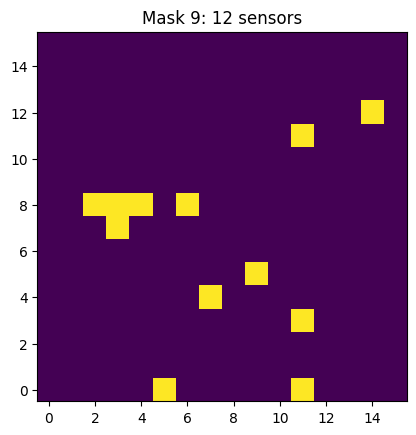

In [7]:
# check masks
masks = np.load("./ckpt/random_mask/mask_n10_range5_15.npy")

mask_id = 9
plt.imshow(masks[mask_id][0], origin='lower')
plt.title(f"Mask {mask_id}: {int(masks[mask_id].sum())} sensors")
plt.show()

In [8]:
# generate dataset from the original dataset
from torch.utils.data import DataLoader
masks = torch.tensor(masks, device=device) # [n_masks, w, h]

# train dataset
mod_train_data = []
for batch in train_loader.dataset:
    y = batch['y'].to(device).float()
    for mask in masks:
        x_mod = (y * mask).float()
        x_embed = torch.cat([x_mod, mask], dim=0) # [2, w, h]
        mod_train_data.append({'x': x_embed, 'y': y})
        
mod_train_loader = DataLoader(mod_train_data, batch_size=32, shuffle=True)

mod_test_loaders = {}
for res, test_loader in test_loaders.items():
    mod_test_data = []
    for batch in test_loader.dataset:
        for mask in masks:
            y = batch['y'].to(device).float()
            x_mod = y * mask.float()
            x_embed = torch.cat([x_mod, mask], dim=0) # [2, w, h]
            mod_test_data.append({'x': x_embed, 'y': y})

    mod_test_loaders[res] = DataLoader(mod_test_data,
                                       batch_size=test_loader.batch_size,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True)
    
print(f"Train dataset size: {len(mod_train_data)}")
print(f"Test dataset size: {len(mod_test_data)}")

Train dataset size: 10000
Test dataset size: 500


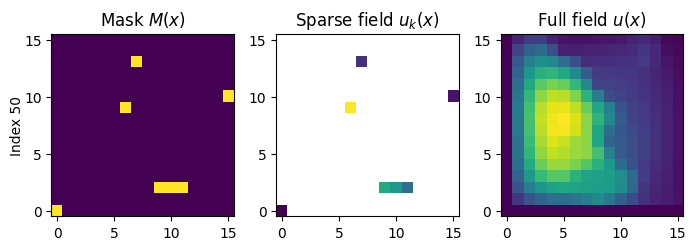

In [ ]:
# check testdata

index = 50
data = mod_test_loaders[16].dataset[index]
x = data['x']
y = data['y']

fig = plt.figure(figsize=(7, 2.5))
ax = fig.add_subplot(1, 3, 1)
ax.annotate(f"Index {index}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
ax.imshow(x[1], origin='lower')
ax.set_title('Mask $M(x)$')

ax = fig.add_subplot(1, 3, 2)
masked_x = np.ma.masked_where(x[0] == 0, x[0])
mod_cmap = plt.cm.viridis.copy()
mod_cmap.set_bad(color='white') 
ax.imshow(masked_x, cmap=mod_cmap, origin='lower')
ax.set_title('Sparse field $u_k(x)$')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(y.squeeze(), origin='lower')
ax.set_title('Full field $u(x)$')
plt.tight_layout()
plt.show()

In [72]:
# model setup
model = FNO(n_modes=(16, 16),
             in_channels=2,
             out_channels=1,
             hidden_channels=64,
             n_layers=4,
             positional_embedding="grid",
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4769601 parameters.


In [73]:
# model setup
optimizer = AdamW(model.parameters(),
                                lr=4e-3,
                                weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# loss functions
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}


print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(1

In [74]:
# train
trainer = Trainer(model=model, n_epochs=100,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=mod_train_loader,
              test_loaders=mod_test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses,
              save_every=10,
              save_dir="./ckpt/random_mask/",
              # resume_from_dir="./ckpt/sparse_mask/"
              )

Training on 10000 samples
Testing on [500] samples         on resolutions [16].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=50.54, avg_loss=0.6262, train_err=20.0060
Eval: 16_h1=0.5343, 16_l2=0.2872
[Rank 0]: saved training state to ./ckpt/random_mask/
[1] time=60.47, avg_loss=0.5401, train_err=17.2551
Eval: 16_h1=0.5211, 16_l2=0.2772
[2] time=52.05, avg_loss=0.5246, train_err=16.7597
Eval: 16_h1=0.5097, 16_l2=0.2654
[3] time=68.28, avg_loss=0.5127, train_err=16.3810
Eval: 16_h1=0.5123, 16_l2=0.2701
[4] time=69.65, avg_loss=0.5038, train_err=16.0972
Eval: 16_h1=0.5082, 16_l2=0.2642
[5] time=68.73, avg_loss=0.4929, train_err=15.7466
Eval: 16_h1=0.5122, 16_l2=0.2707
[6] time=53.89, avg_loss=0.4819, train_err=15.3963
Eval: 16_h1=0.5118, 16_l2=0.2652
[7] time=54.58, avg_loss=0.4668, train_err=14.9148
Eval: 16_h1=0.5172, 16_l2=0.2656
[8] time=56.31, avg_loss=0.4516, train_err=14.4277
Eval: 16_h1=0.5129, 16_l2=0.2653
[9] time=55.77, avg_loss=0.4332, train_err=13.8394
Eval: 16_h

{'train_err': 3.542990723357033,
 'avg_loss': 0.11089560964107513,
 'avg_lasso_loss': None,
 'epoch_train_time': 92.64804419999928,
 '16_h1': tensor(0.5670),
 '16_l2': tensor(0.2850)}

In [75]:
# save model
model.save_checkpoint(save_folder='./model', save_name='fno_random_mask')

In [4]:
# reload model
model_reload = FNO.from_checkpoint('./model', save_name='fno_random_mask')

C:\Users\liuya\AppData\Local\Temp\ipykernel_15564\2153727311.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


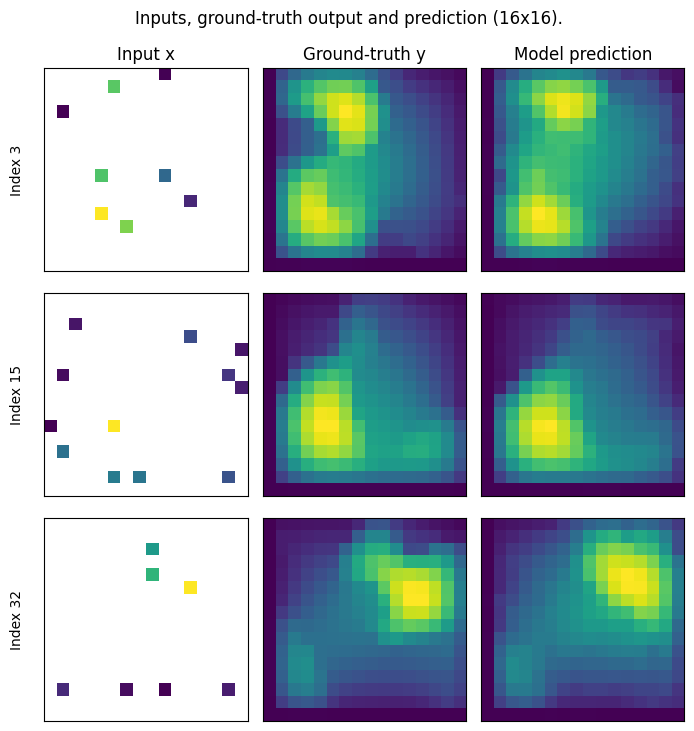

In [24]:
# test known mask
# model_use = model
model_use = model_reload

test_samples = mod_test_loaders[16].dataset

tests = [3, 15, 32]

fig = plt.figure(figsize=(7, 2.5*len(tests)))
for ind, test_id in enumerate(tests):
    data = test_samples[test_id]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model_use(x.unsqueeze(0)).squeeze().detach().numpy()

    ax = fig.add_subplot(len(tests), 3, ind*3 + 1)
    ax.annotate(f"Index {test_id}", xy=(-0.1, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
    masked_x = np.ma.masked_where(x[0] == 0, x[0])
    mod_cmap = plt.cm.viridis.copy()
    mod_cmap.set_bad(color='white') 
    ax.imshow(masked_x, cmap=mod_cmap, origin='lower')
    # ax.imshow(x[1], origin='lower')
    if ind == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, ind*3 + 2)
    ax.imshow(y.squeeze(), origin='lower')
    if ind == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, ind*3 + 3)
    ax.imshow(out, origin='lower')
    if ind == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()


In [28]:
# build new mask to test model with unknown masks
n_masks=3
n_range=(10,15)
masks = generate_masks(n_masks=3, grid_shape=(1,16,16), num_sensor_range=(10,15))
np.save(f"./ckpt/random_mask/mask_n{n_masks}_range{n_range[0]}_{n_range[1]}.npy", masks)

In [33]:
masks = torch.tensor(masks, device=device)

unknown_mask_test_loaders = {}
for res, test_loader in test_loaders.items():
    mod_test_data = []
    for batch in test_loader.dataset:
        for mask in masks:
            y = batch['y'].to(device).float()
            x_mod = y * mask.float()
            x_embed = torch.cat([x_mod, mask], dim=0) # [2, w, h]
            mod_test_data.append({'x': x_embed, 'y': y})

    unknown_mask_test_loaders[res] = DataLoader(mod_test_data,
                                       batch_size=test_loader.batch_size,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True)

C:\Users\liuya\AppData\Local\Temp\ipykernel_15564\3723043401.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


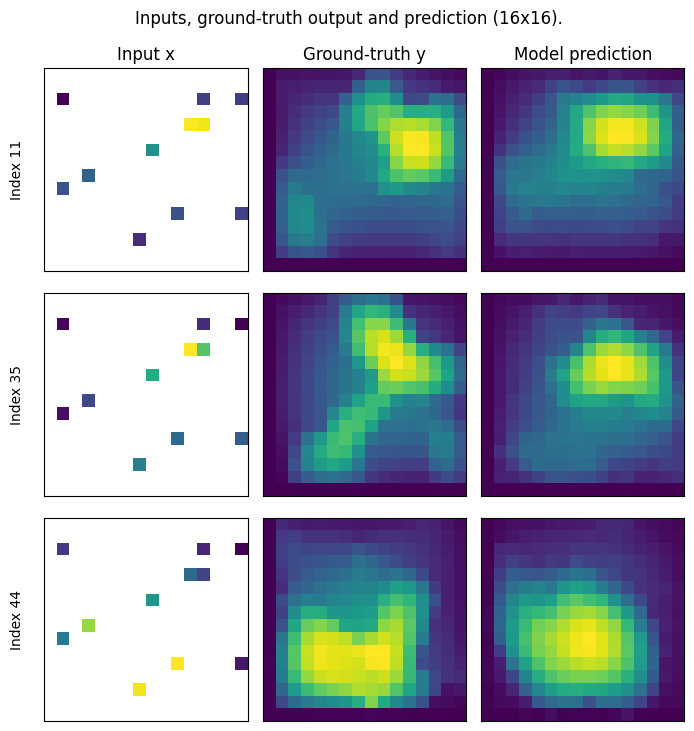

In [62]:
# test known mask
# model_use = model
model_use = model_reload

test_samples = unknown_mask_test_loaders[16].dataset

tests = [11, 35, 44]

fig = plt.figure(figsize=(7, 2.5*len(tests)))
for ind, test_id in enumerate(tests):
    data = test_samples[test_id]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model_use(x.unsqueeze(0)).squeeze().detach().numpy()

    ax = fig.add_subplot(len(tests), 3, ind*3 + 1)
    ax.annotate(f"Index {test_id}", xy=(-0.1, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
    masked_x = np.ma.masked_where(x[0] == 0, x[0])
    mod_cmap = plt.cm.viridis.copy()
    mod_cmap.set_bad(color='white') 
    ax.imshow(masked_x, cmap=mod_cmap, origin='lower')
    # ax.imshow(x[1], origin='lower')
    if ind == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, ind*3 + 2)
    ax.imshow(y.squeeze(), origin='lower')
    if ind == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, ind*3 + 3)
    ax.imshow(out, origin='lower')
    if ind == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()
